In [ ]:
import cx_Oracle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
plt.rc('font', family = 'Malgun Gothic') # 한글 입력
plt.rcParams['axes.unicode_minus'] = False # 글꼴 변경시 마이너스 표기 가능으로 처리
# 계절성 보정 사용자 함수

def new_seasonal_scaled(df):
    df1 = df.copy()
    df1.loc[df1['기'] == '1기', '총구매액'] = np.round(df1.loc[df1['기'] == '1기', '총구매액'] / 0.9476399112)
    df1.loc[df1['기'] == '2기', '총구매액'] = np.round(df1.loc[df1['기'] == '2기', '총구매액'] / 0.9785290501)
    df1.loc[df1['기'] == '3기', '총구매액'] = np.round(df1.loc[df1['기'] == '3기', '총구매액'] / 0.9072731695)
    df1.loc[df1['기'] == '4기', '총구매액'] = np.round(df1.loc[df1['기'] == '4기', '총구매액'] / 1.166557869)
    df1.loc[df1['기'] == '5기', '총구매액'] = np.round(df1.loc[df1['기'] == '5기', '총구매액'] / 0.9748289537)
    df1.loc[df1['기'] == '6기', '총구매액'] = np.round(df1.loc[df1['기'] == '6기', '총구매액'] / 0.9784250528)
    df1.loc[df1['기'] == '7기', '총구매액'] = np.round(df1.loc[df1['기'] == '7기', '총구매액'] / 0.912781587)
    df1.loc[df1['기'] == '8기', '총구매액'] = np.round(df1.loc[df1['기'] == '8기', '총구매액'] / 1.133964406)
    df1['총구매액'] = df1['총구매액'].astype('int64')
    return df1 
# 고정고객으로 정의한 고객 정보 불러오기
con = cx_Oracle.connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql = '''SELECT a.고객번호, a.성별, a.연령대, d.지역, a.세분류명, a.분류, b.고객구분, c.기, sum(a.구매금액) "총구매액"
FROM LCL a
JOIN 증감고객 b ON a.고객번호 = b.고객번호
JOIN 기기 c ON a.연도 = c.연도 AND a.분기 = c.분기
JOIN CUSTDEMO d ON a.고객번호 = d.고객번호 AND a.성별 = d.성별 AND a.연령대 = d.연령대 AND a.거주지역 = d.거주지역
GROUP BY a.고객번호, a.성별, a.연령대, d.지역, a.세분류명, a.분류, b.고객구분, c.기
ORDER BY a.고객번호, a.성별, a.연령대, d.지역, a.세분류명, a.분류, b.고객구분, c.기'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호', '성별', '연령대', '지역', '세분류명', '분류', '고객구분','기','총구매액']
df_all = pd.DataFrame(x, columns = columns)
cursor.close()
con.commit()
con.close()
df_all = seasonal_scaled(df_all).copy()
display(df_all.head())

In [2]:
# 2014, 2015, 2년 합산 매출, 증감률

con = cx_Oracle .connect('LM_PDB/LM@localhost:1521/xepdb1')
cursor = con.cursor()
sql ='''select a.*, nvl(채널이용횟수, 0) 채널이용횟수, nvl(경쟁사이용횟수, 0) 경쟁사이용횟수, nvl(멤버십가입개수, 0) 멤버십가입개수
from
고정고객 a
left outer join 
(SELECT 고객번호, SUM(이용횟수) 채널이용횟수 FROM CHANNEL
GROUP BY 고객번호) b on a.고객번호 = b.고객번호
left outer join 
(SELECT 고객번호, COUNT(고객번호) 경쟁사이용횟수 FROM COMPET
GROUP BY 고객번호) c on a.고객번호 = c.고객번호
left outer join
(select 고객번호, count(고객번호) 멤버십가입개수 FROM membership
group by 고객번호) d on a.고객번호 = d.고객번호'''
cursor.execute(sql)
x = cursor.fetchall()
columns = ['고객번호','이용금액 1분기', '이용금액 2분기','이용금액 3분기', '이용금액 4분기','이용금액 5분기','이용금액 6분기','이용금액 7분기', '이용금액 8분기','고객구분','분기합평균','채널이용횟수', '경쟁사이용횟수', '멤버십가입개수']
df1 = pd.DataFrame(x,columns=columns)
display(df1)
cursor.close()
con.commit()
con.close()

,고객번호,이용금액 1분기,이용금액 2분기,이용금액 3분기,이용금액 4분기,이용금액 5분기,이용금액 6분기,이용금액 7분기,이용금액 8분기,고객구분,분기합평균,채널이용횟수,경쟁사이용횟수,멤버십가입개수
0,00208,10693376,16846715,16453755,14733980,9561677,1315829,702808,128161,감소,11600889,0,0,0
1,00209,3782829,1679858,2396160,2842676,831787,3737997,1990426,806895,감소,2545218,0,8,0
2,00210,495943,692646,848845,835159,679068,920517,942023,783208,증가,745363,5,0,0
3,00211,1725233,852406,3018628,1076638,4336443,2192074,5033964,3667179,증가,2200237,0,0,0
4,00212,2727154,2516544,2602235,3049512,1639453,4389155,2246216,1437559,감소,2820676,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18861,15907,9818375,10610335,9350138,8101261,9708060,6013900,17361645,7451821,증가,8933678,0,4,1
18862,15908,2072940,1934031,2824044,1700517,2288566,2296559,2280750,1749501,증가,2186110,0,0,0
18863,15909,833420,846127,732095,673168,725640,863181,584795,467631,감소,778938,0,0,0
18864,15910,1754890,2254717,1912665,1448370,2022081,1812975,2168299,1099406,증가,1867616,0,0,1


Text(0.5, 1.0, '감소고객')

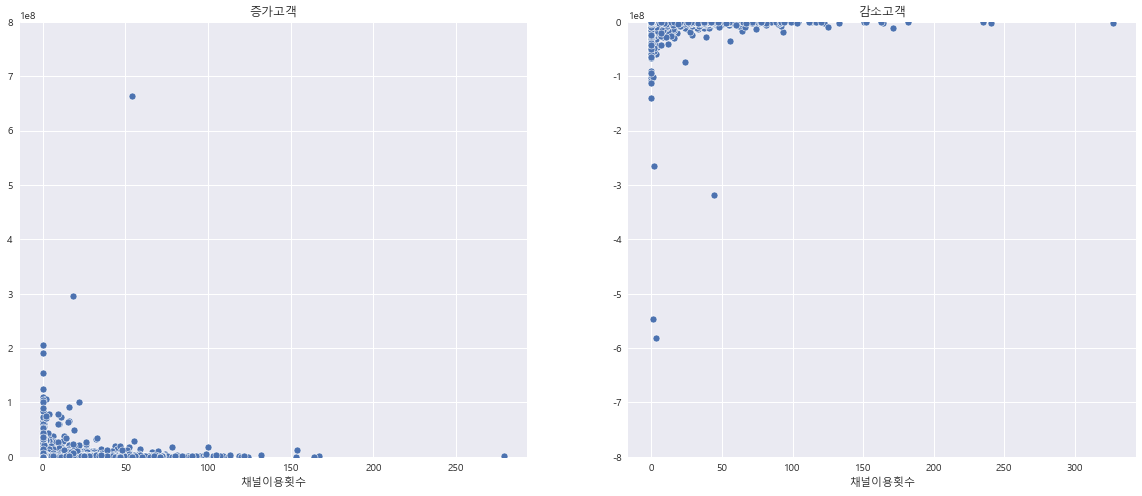

In [30]:
# 채널이용횟수와 증감 사이의 관계
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1) 
sns.scatterplot(data=df1.loc[df1.고객구분 == '증가'], x='채널이용횟수', y = df1['이용금액 7분기']-df1['이용금액 1분기'])
plt.ylim(0,8*1e8)
plt.title('증가고객')

plt.subplot(1, 2, 2) 
sns.scatterplot(data=df1.loc[df1.고객구분 == '감소'], x='채널이용횟수', y = df1['이용금액 7분기']-df1['이용금액 1분기'])
plt.ylim(-8*1e8,0)
plt.title('감소고객')

Text(0.5, 1.0, '감소고객')

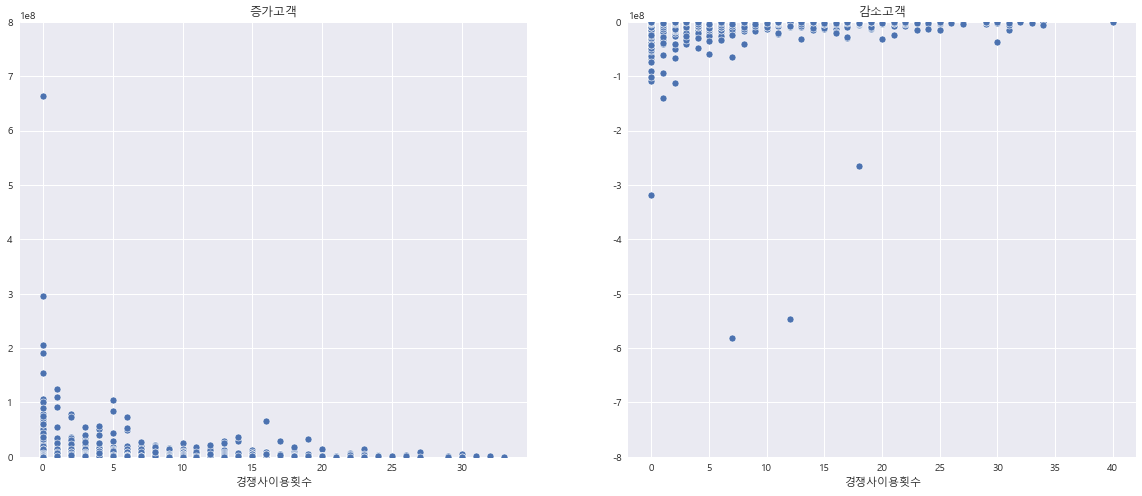

In [29]:
# 경쟁사이용횟수와 증감 사이의 관계
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1) 
sns.scatterplot(data=df1.loc[df1.고객구분 == '증가'], x='경쟁사이용횟수', y = df1['이용금액 7분기']-df1['이용금액 1분기'])
plt.ylim(0,8*1e8)
plt.title('증가고객')

plt.subplot(1, 2, 2) 
sns.scatterplot(data=df1.loc[df1.고객구분 == '감소'], x='경쟁사이용횟수', y = df1['이용금액 7분기']-df1['이용금액 1분기'])
plt.ylim(-8*1e8,0)
plt.title('감소고객')

Text(0.5, 1.0, '감소고객')

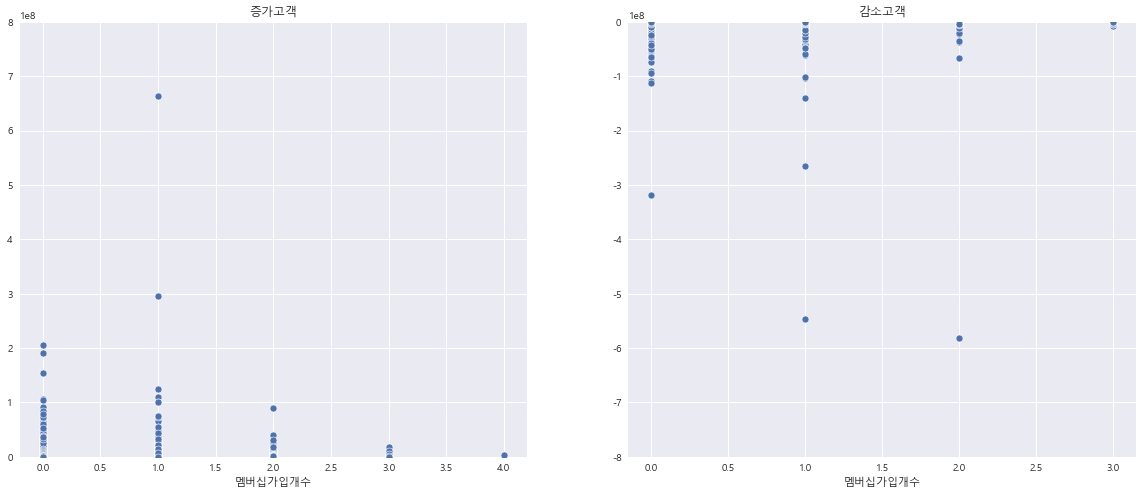

In [31]:
# 멤버십가입개수와 증감 사이의 관계
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1) 
sns.scatterplot(data=df1.loc[df1.고객구분 == '증가'], x='멤버십가입개수', y = df1['이용금액 7분기']-df1['이용금액 1분기'])
plt.ylim(0,8*1e8)
plt.title('증가고객')

plt.subplot(1, 2, 2) 
sns.scatterplot(data=df1.loc[df1.고객구분 == '감소'], x='멤버십가입개수', y = df1['이용금액 7분기']-df1['이용금액 1분기'])
plt.ylim(-8*1e8,0)
plt.title('감소고객')

Text(0.5, 1.0, '증가고객')

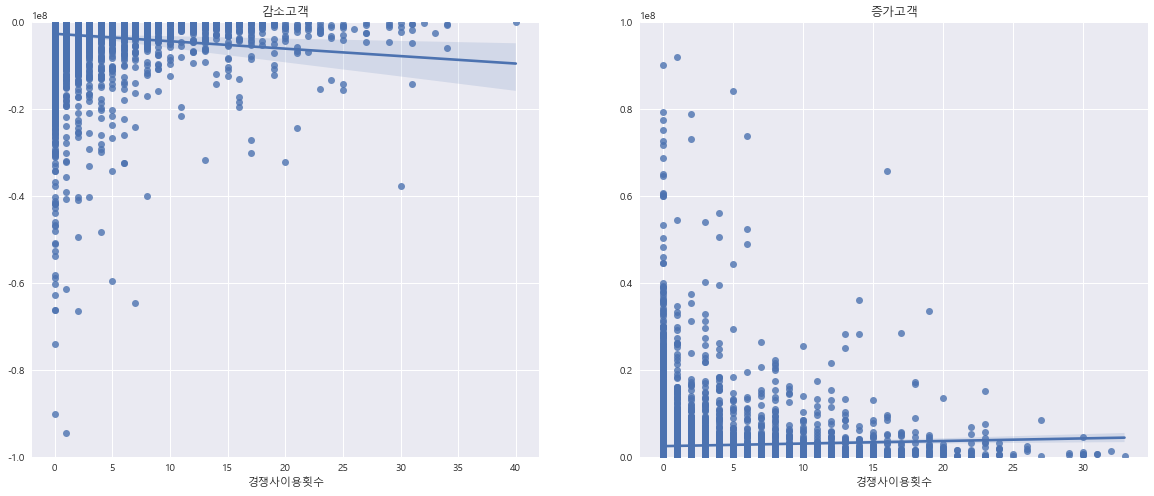

In [48]:
# 경쟁사이용횟수와 증감 사이의 관계
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1) 
df_down = df1.loc[df1.고객구분 == '감소']
sns.regplot(data=df_down, x='경쟁사이용횟수', y = df_down['이용금액 7분기']-df_down['이용금액 1분기'])
plt.ylim(-1*1e8,0)
plt.title('감소고객')

plt.subplot(1, 2, 2) 
df_up = df1.loc[df1.고객구분 == '증가']
sns.regplot(data=df_up, x='경쟁사이용횟수', y = df_up['이용금액 7분기']-df_up['이용금액 1분기'])
plt.ylim(0,1*1e8)
plt.title('증가고객')


Text(0.5, 1.0, '증가고객')

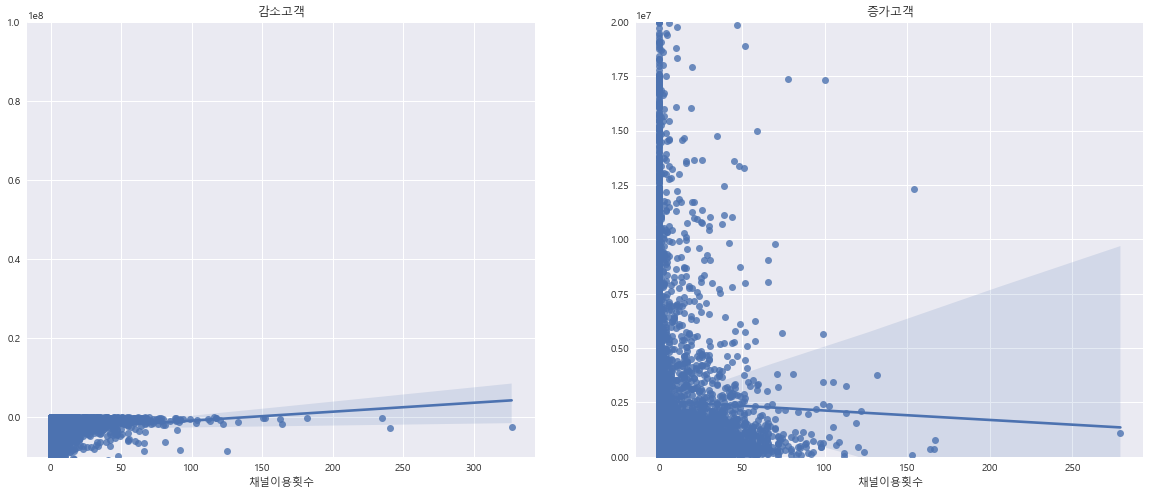

In [54]:
# 채널이용횟수와 증감 사이의 관계
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1) 
df_down = df1.loc[df1.고객구분 == '감소']
sns.regplot(data=df_down, x='채널이용횟수', y = df_down['이용금액 7분기']-df_down['이용금액 1분기'])
plt.ylim(-0.1*1e8,1*1e8)
plt.title('감소고객')

plt.subplot(1, 2, 2) 
df_up = df1.loc[df1.고객구분 == '증가']
sns.regplot(data=df_up, x='채널이용횟수', y = df_up['이용금액 7분기']-df_up['이용금액 1분기'])
plt.ylim(0,0.2*1e8)
plt.title('증가고객')

Text(0.5, 1.0, '증가고객')

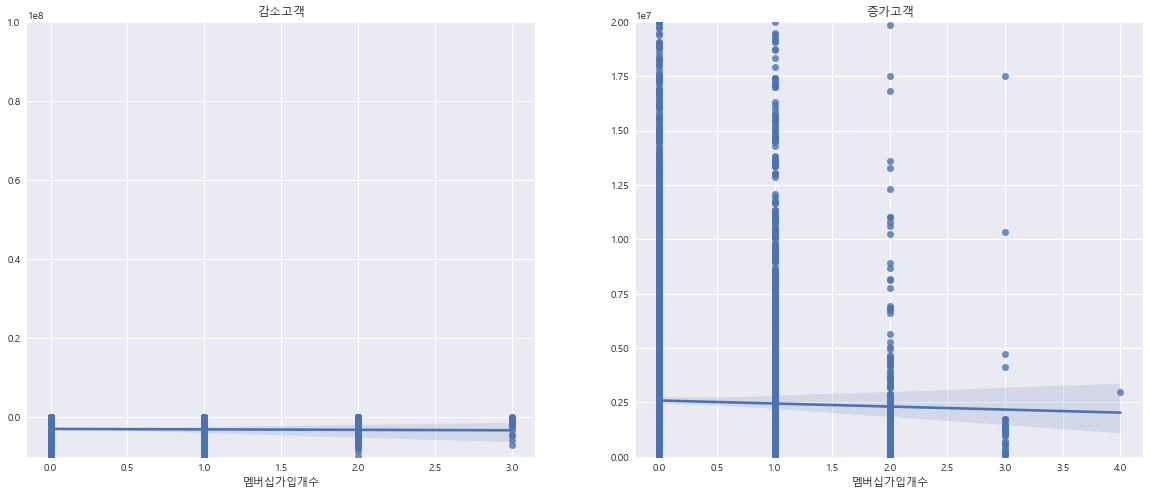

In [55]:
# 멤버십가입개수와 증감 사이의 관계
plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1) 
df_down = df1.loc[df1.고객구분 == '감소']
sns.regplot(data=df_down, x='멤버십가입개수', y = df_down['이용금액 7분기']-df_down['이용금액 1분기'])
plt.ylim(-0.1*1e8,1*1e8)
plt.title('감소고객')

plt.subplot(1, 2, 2) 
df_up = df1.loc[df1.고객구분 == '증가']
sns.regplot(data=df_up, x='멤버십가입개수', y = df_up['이용금액 7분기']-df_up['이용금액 1분기'])
plt.ylim(0,0.2*1e8)
plt.title('증가고객')